<a href="https://colab.research.google.com/github/valeriu-balaban/fair-ml-presentation/blob/main/Fair_ML_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Fair ML Models

 - Fairness will play a major role in automated systems such as ML
 - For now we do not always have many answers, just a lot of questions
 - Let's make it interactive. Think and answer questions 
 - There is no right of wrong answer
 - Presented methods can be easily integrated in any project
 - Code is in vanila Pytorch and can be ported to Keras, Tensorflow, JAX, etc.

**Outline:**
1. When things go wrong, examples
1. Datasets description
1. Subgroup, individual fairness
1. Definition and fairness metrics
1. Conditional Value at Risk method
1. Wasserstein distance (maybe)
1. Variance penalization and reference group

## 1. Problem with $``the\ algorithm"$ 


  - Tiktok's algorithm prioritizes white people:
    ![tiktok](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-31-32%20tiktok%20race%20problem%20at%20DuckDuckGo.png)

  - Youtube's algorithm has other issues ([source](https://www.wsj.com/articles/youtubes-search-algorithm-directs-viewers-to-false-and-sexualized-videos-study-finds-11625644803)):
  ![youtube](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-30-24%20YouTube%E2%80%99s%20Search%20Algorithm%20Directs%20Viewers%20to%20False%20and%20Sexualized%20Videos%2C%20Study%20Finds.png)

  - Facebook's algorithm has ome other problems ([source](https://www.technologyreview.com/2019/04/05/1175/facebook-algorithm-discriminates-ai-bias/)):
  ![facebook](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-35-14%20Facebook%E2%80%99s%20ad-serving%20algorithm%20discriminates%20by%20gender%20and%20race.png)

  - And the same problem can be posed for self-driving cars ([source](https://www.technologyreview.com/2018/10/24/139313/a-global-ethics-study-aims-to-help-ai-solve-the-self-driving-trolley-problem/))
  ![self-driving-cars](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2012-01-08%20Should%20a%20self-driving%20car%20kill%20the%20baby%20or%20the%20grandma%20Depends%20on%20where%20you%E2%80%99re%20from%20.png)

  - Evaluating the danger of an offender during (pre)trial ([source](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm))
    ![propublica](https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/methodology-risk-of-recidivism-scores-by-race-900*363-482d1c.png)



None of these companies designed the ML algorithm to be biased. Yet it ended up biased on multiple occasions. 

**Why?**

### Answer

*Learning from data without suppervision can (usually does) lead to issues because humans that generate the data discriminate by race, skin color, gender, age, etc.*

https://www.youtube.com/embed/NaWJhlDb6sE



## 2. Toy dataset 

In [2]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [50]:
def generate_toy_data(n_samples, n_samples_low, n_dimensions, seed=0):
  """
  Dataset generation code from Michele Donini, et al. "Empirical Risk
  Minimization under Fairness Constraints. https://github.com/jmikko/fair_ERM
  """
  np.random.seed(seed)
  varA = 0.8
  aveApos = [-1.0] * n_dimensions
  aveAneg = [1.0] * n_dimensions
  varB = 0.5
  aveBpos = [0.5] * int(n_dimensions / 2) + [-0.5] * int(n_dimensions / 2 + n_dimensions % 2)
  aveBneg = [0.5] * n_dimensions
  X = np.random.multivariate_normal(aveApos, np.diag([varA] * n_dimensions), n_samples)
  X = np.vstack([X, np.random.multivariate_normal(aveAneg, np.diag([varA] * n_dimensions), n_samples)])
  X = np.vstack([X, np.random.multivariate_normal(aveBpos, np.diag([varB] * n_dimensions), n_samples_low)])
  X = np.vstack([X, np.random.multivariate_normal(aveBneg, np.diag([varB] * n_dimensions), n_samples)])
  sensible_feature = [1] * (n_samples * 2) + [-1] * (n_samples + n_samples_low)
  sensible_feature = np.array(sensible_feature)
  sensible_feature.shape = (len(sensible_feature), 1)
  X = np.hstack([X, sensible_feature])
  y = [1] * n_samples + [-1] * n_samples + [1] * n_samples_low + [-1] * n_samples
  y = np.array(y)
  sensible_feature_id = len(X[1, :]) - 1
  idx_A = list(range(0, n_samples * 2))
  idx_B = list(range(n_samples * 2, n_samples * 3 + n_samples_low))

  return X, y, sensible_feature_id, idx_A, idx_B

In [51]:
# Parameters
n_samples = 100
n_samples_low = 20

# Prepare the dataset
X, y, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=3)

In [52]:
X[0, :], y

(array([ 0.59979794, -0.60957372,  1.        ]),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,

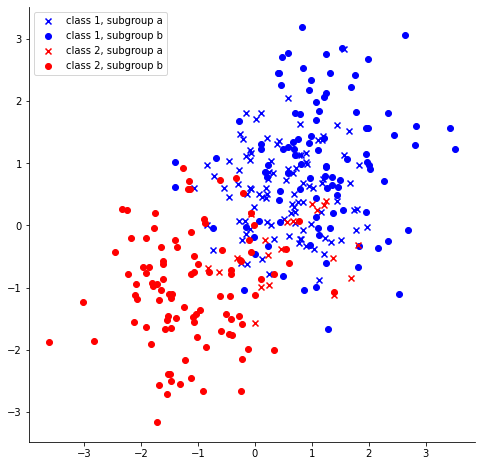

In [54]:
# Plot data
s1 = (X[:, 2] < 0)
s2 = (X[:, 2] > 0)

c1s1 = (y[s1] == -1)
c1s2 = (y[s2] == -1)
c2s1 = (y[s1] ==  1)
c2s2 = (y[s2] ==  1)


plt.figure(figsize=(8, 8))

plt.scatter(X[s1, 0][c1s1], X[s1, 1][c1s1], marker='x', color='b', label="class 1, subgroup a")
plt.scatter(X[s2, 0][c1s2], X[s2, 1][c1s2], marker='o', color='b', label="class 1, subgroup b")

plt.scatter(X[s1, 0][c2s1], X[s1, 1][c2s1], marker='x', color='r', label="class 2, subgroup a")
plt.scatter(X[s2, 0][c2s2], X[s2, 1][c2s2], marker='o', color='r', label="class 2, subgroup b")

plt.legend()
sns.despine()

**Questions:**
1. What differentiates subgroup a from subgroup b?
1. How a fair classification boundary should look?

### Train a vanila pytorch model

In [82]:
# data parameters
n_samples = 1000
n_samples_low = 200

# Prepare the dataset
X, y, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=0)
X_test, y_test, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=1)

X = torch.tensor(X).float()
X_test = torch.tensor(X_test).float()

# Change labels from -1, 1 to 0, 1
y = torch.tensor(y)
y[y == -1] = 0

y_test = torch.tensor(y_test)
y_test[y_test == -1] = 0


data_train = torch.utils.data.TensorDataset(X, y)
loss       = torch.nn.CrossEntropyLoss(reduction='none')

In [83]:
# Params
num_epochs = 10
lr = 0.02
batch_size = 256

model = torch.nn.Sequential(
  torch.nn.Linear(3, 8),
  torch.nn.Sigmoid(),
  torch.nn.Linear(8, 2),
)

opt  = torch.optim.Adam(model.parameters(), lr=lr)
dl   = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)


for i in range(num_epochs):
  print("Training epoch", i)

  for x, y_t in dl:
    opt.zero_grad()

    y_hat  = model(x)
    losses = loss(y_hat, y_t)


    # Backpropagate and optimize    
    losses.mean().backward()
    opt.step()

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9


In [84]:
# Evaluate model

with torch.no_grad():
  y_hat = model(X_test)

y_class = y_hat.argmax(dim=1)


print("Number of missclassifications", (y_class != y_test).sum().item(), "out of", y_test.shape[0], "or", (y_class != y_test).sum().item() /  y_test.shape[0])

Number of missclassifications 303 out of 3200 or 0.0946875


In [85]:
y_mask  = (y_class != y_test)
x_group = X_test[:, 2][y_mask]

print("Number of missclassifications for subgroup a", (x_group < 0).sum().item(), "out of", y_test.shape[0], "or", (x_group < 0).sum().item() /  y_test.shape[0])
print("Number of missclassifications for subgroup b", (x_group > 0).sum().item(), "out of", y_test.shape[0], "or", (x_group > 0).sum().item() /  y_test.shape[0])

Number of missclassifications for subgroup a 181 out of 3200 or 0.0565625
Number of missclassifications for subgroup b 122 out of 3200 or 0.038125


**Questions:**
1. The subgroup attribute is part of the training data. Would the results change if we remove it?
1. How can we fix this and make the model more fair? 

## Definition and fainess metrics


### Notation:

To simplify things we will focus only on classification. Although, the methods work for both, regression and classification.


- $X$ - input ($x$ one input sample)
- $Y$ - labels ($y$ one label sample)
- $S$ - sensitive attributes which are part of X (e.g., gender, age, race)
- $f$ - model we train, i.e., $f(x; \theta)$ returns the probability of each labels
- $\theta$ - model parameters, e.g., the weights and the biases for NN
- $\ell$ - loss function, here we will always use cross-entropy ($-log f(x; \theta) [y]$)
- $\mathbb{E}[\ell(f, X, Y)]$ - loss value, i.e., average loss
- $\min\mathbb{E}[\ell(f, X, Y)]$ - optimization objective

### Definitions of perfect fairness



- *Demografic parity:* $S \perp f(X; \theta)$
- *Equaized odds:* $S \perp f(X; \theta) \mid Y$
- *Lack of disparate mistreatment:* $\mathbb{P}(f(X; \theta) \neq Y \mid S = s_a) = \mathbb{P}(f(X; \theta) \neq Y \mid S = s_b) , \forall s_a, s_b \in S$

**Questions:**
1. What is the difference between the first two from the perspective of application?
1. What is the problem with these definitions?

### Approximate fairness

- *Mean difference score:* $\max \mid \mathbb{P}(f(X; \theta) = y \mid S = s_a) - \mathbb{P}(f(X; \theta) = y \mid S = s_b) \mid, \forall s_a, s_b \in S, \forall y \in Y$

- *Covariance:* $\mathbb{E}[f(X; \theta) \cdot S] - \mathbb{E}[f(X; \theta)] \cdot \mathbb{E}[S]$

**Questions:**
1. Why these two metrics are approximate
1. Why we use the approximate metrics instead of perfect metrics of fairness?

[Correlation Wikipedia](https://en.wikipedia.org/wiki/Correlation)

In [193]:
# Params
num_epochs = 10
lr = 0.02
batch_size = 256

rho=1.0
alpha=0.5
sensitive_idx=2

model = torch.nn.Sequential(
  torch.nn.Linear(3, 8),
  torch.nn.Sigmoid(),
  torch.nn.Linear(8, 2),
)

rho  = torch.tensor(rho, requires_grad=True)

opt  = torch.optim.Adam([rho] + list(model.parameters()), lr=lr)
dl   = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)


for i in range(num_epochs):
  print("Training epoch", i)

  for x, y_t in dl:
    opt.zero_grad()

    y_hat  = model(x)
    losses = loss(y_hat, y_t)
    l_mean = losses.mean().detach()

    groups = x[:,sensitive_idx].unique()
    sum    = 0
    for c in groups:
      mask = (x[:,sensitive_idx] == c)
      sum += (losses[mask].mean() - rho).clip(0.0)

    (rho + 1/(1-alpha)* sum / groups.shape[0]).backward()

    opt.step()

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9


In [194]:
# Evaluate model

with torch.no_grad():
  y_hat = model(X_test)

y_class = y_hat.argmax(dim=1)


print("Number of missclassifications", (y_class != y_test).sum().item(), "out of", y_test.shape[0], "or", (y_class != y_test).sum().item() /  y_test.shape[0])

Number of missclassifications 351 out of 3200 or 0.1096875


In [195]:
y_mask  = (y_class != y_test)
x_group = X_test[:, 2][y_mask]

print("Number of missclassifications for subgroup a", (x_group < 0).sum().item(), "out of", y_test.shape[0], "or", (x_group < 0).sum().item() /  y_test.shape[0])
print("Number of missclassifications for subgroup b", (x_group > 0).sum().item(), "out of", y_test.shape[0], "or", (x_group > 0).sum().item() /  y_test.shape[0])

Number of missclassifications for subgroup a 171 out of 3200 or 0.0534375
Number of missclassifications for subgroup b 180 out of 3200 or 0.05625


(array([0.7089362 , 0.35446806, 1.06340417, 0.35446823, 1.06340417,
        0.35446806, 1.06340417, 1.77234029, 1.77234029, 1.77234198,
        2.83574446, 1.77234029, 1.77234029, 2.12680835, 1.06340519,
        3.54467721, 4.60808914, 0.35446772, 2.48127877, 3.19020949,
        1.77234198, 1.41787358, 1.41787088, 3.89915235, 3.19020949,
        2.12681037, 2.12680633, 4.96255753, 3.54467721, 5.31702593]),
 array([0.02916896, 0.04484189, 0.06051483, 0.07618777, 0.0918607 ,
        0.10753363, 0.12320657, 0.13887951, 0.15455244, 0.17022538,
        0.1858983 , 0.20157124, 0.21724418, 0.23291712, 0.24859005,
        0.26426297, 0.27993593, 0.29560885, 0.3112818 , 0.32695472,
        0.34262767, 0.3583006 , 0.37397352, 0.38964647, 0.4053194 ,
        0.42099234, 0.43666527, 0.45233822, 0.46801114, 0.4836841 ,
        0.499357  ], dtype=float32),
 <a list of 30 Patch objects>)

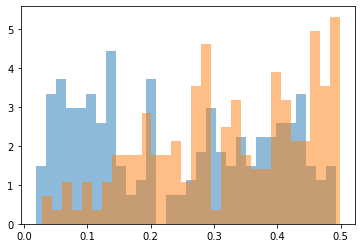

In [196]:
# Select predicted prob by subgroup
pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True)
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True)

(array([0.33919933, 0.20351885, 0.44095913, 0.4409575 , 0.54271893,
        0.61055654, 0.50879899, 0.64447872, 0.54271693, 0.61055879,
        0.88191501, 0.78015846, 0.74623578, 0.37311926, 0.78015558,
        0.91583819, 0.81407839, 0.8479952 , 1.62815678, 2.06910829,
        1.28895745, 2.00126867, 2.13695577, 3.29023349, 3.66333927,
        5.56286899, 7.15707949, 8.64958288, 6.71612199, 6.54654704]),
 array([0.5021887 , 0.51838714, 0.53458565, 0.5507841 , 0.5669826 ,
        0.5831811 , 0.5993796 , 0.61557806, 0.6317765 , 0.647975  ,
        0.6641735 , 0.680372  , 0.69657046, 0.712769  , 0.7289674 ,
        0.74516594, 0.7613644 , 0.77756286, 0.7937614 , 0.8099598 ,
        0.82615834, 0.8423568 , 0.8585553 , 0.8747538 , 0.8909522 ,
        0.90715075, 0.9233492 , 0.9395477 , 0.9557462 , 0.9719447 ,
        0.98814315], dtype=float32),
 <a list of 30 Patch objects>)

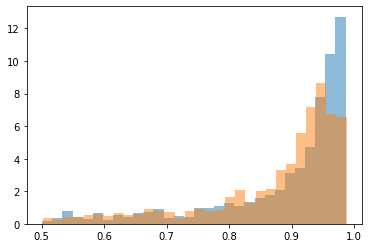

In [197]:
# Select predicted prob by subgroup
y_mask  = (y_class == y_test)
x_group = X_test[:, 2][y_mask]


pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True)
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True)

## Moments penalization

In [203]:
# Params
num_epochs = 10
lr = 0.02
batch_size = 256

lambda_1 = 1.0
lambda_2 = 16.0
lambda_3 = 2.0
lambda_4 = 0.0
sensitive_idx=2

model = torch.nn.Sequential(
  torch.nn.Linear(3, 8),
  torch.nn.Sigmoid(),
  torch.nn.Linear(8, 2),
)

opt  = torch.optim.Adam(model.parameters(), lr=lr)
dl   = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

logs = []

for i in range(num_epochs):
  for x, y_t in dl:
    opt.zero_grad()

    y_hat  = model(x)
    losses = loss(y_hat, y_t)

    z      = losses.detach()
    z_mean = z.mean()


    # Calculate mean loss for each class
    class_mean_loss = torch.zeros_like(z)
    lambda_2v       = lambda_2 * torch.ones_like(z)
    lambda_3v       = lambda_3 * torch.ones_like(z)
    lambda_4v       = lambda_4 * torch.ones_like(z)

    for c in x[:,sensitive_idx].unique():
      mask = (x[:,sensitive_idx] == c)
      class_mean_loss[mask] = z[mask].mean()

    # Calculate weights
    w = lambda_1 + lambda_2v * (class_mean_loss/z_mean - z_mean/z_mean) + \
        lambda_3v * (z - class_mean_loss - z.var()/z_mean) + \
        lambda_4v * ((z - class_mean_loss)**2 - (z - z_mean)**3 / z_mean)
    w = w.clip(0.0)

    # Backpropagate and optimize    
    (w * losses).mean().backward()
    opt.step()

In [204]:
# Evaluate model

with torch.no_grad():
  y_hat = model(X_test)

y_class = y_hat.argmax(dim=1)


print("Number of missclassifications", (y_class != y_test).sum().item(), "out of", y_test.shape[0], "or", (y_class != y_test).sum().item() /  y_test.shape[0])

Number of missclassifications 342 out of 3200 or 0.106875


In [205]:
y_mask  = (y_class != y_test)
x_group = X_test[:, 2][y_mask]

print("Number of missclassifications for subgroup a", (x_group < 0).sum().item(), "out of", y_test.shape[0], "or", (x_group < 0).sum().item() /  y_test.shape[0])
print("Number of missclassifications for subgroup b", (x_group > 0).sum().item(), "out of", y_test.shape[0], "or", (x_group > 0).sum().item() /  y_test.shape[0])

Number of missclassifications for subgroup a 172 out of 3200 or 0.05375
Number of missclassifications for subgroup b 170 out of 3200 or 0.053125


(array([ 0.91290576,  0.        ,  0.        ,  0.45645262,  0.        ,
         0.45645314,  0.91290629,  0.91290629,  0.        ,  0.91290629,
         0.        ,  0.        ,  1.82581257,  0.91290629,  2.28226572,
         2.73871886,  4.10807829,  2.73871886,  1.36935626,  3.65162515,
         3.195172  ,  5.02098458,  5.47743772,  3.195172  ,  5.47743772,
         2.28226044,  5.47743772,  6.39034401,  4.56453143, 12.32423487]),
 array([0.11242218, 0.12530927, 0.13819636, 0.15108345, 0.16397056,
        0.17685765, 0.18974474, 0.20263183, 0.21551892, 0.22840603,
        0.24129312, 0.25418022, 0.2670673 , 0.2799544 , 0.2928415 ,
        0.30572858, 0.31861567, 0.33150277, 0.34438986, 0.35727698,
        0.37016407, 0.38305116, 0.39593825, 0.40882534, 0.42171243,
        0.43459952, 0.44748664, 0.46037373, 0.47326082, 0.4861479 ,
        0.499035  ], dtype=float32),
 <a list of 30 Patch objects>)

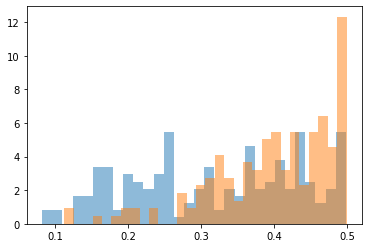

In [206]:
# Select predicted prob by subgroup
pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True)
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True)

(array([0.54839676, 0.65807348, 1.06023373, 0.98711022, 0.91399459,
        1.24302769, 0.98711416, 1.42583156, 1.09678914, 1.20647286,
        1.38926624, 2.2301468 , 1.97422045, 1.93766854, 2.52261501,
        2.92478269, 3.69253815, 3.91188125, 4.09469577, 4.27747763,
        4.86245123, 4.71619329, 2.74198378, 1.93766854, 2.04733972,
        2.70542399, 2.66885357, 2.70542399, 2.33981682, 1.09679351]),
 array([0.50018245, 0.51512915, 0.5300759 , 0.5450226 , 0.55996937,
        0.57491606, 0.5898628 , 0.6048095 , 0.6197562 , 0.634703  ,
        0.6496497 , 0.66459644, 0.67954314, 0.6944899 , 0.7094366 ,
        0.72438335, 0.73933005, 0.75427675, 0.7692235 , 0.7841702 ,
        0.79911697, 0.81406367, 0.8290104 , 0.8439571 , 0.8589038 ,
        0.8738506 , 0.8887973 , 0.90374404, 0.91869074, 0.9336375 ,
        0.9485842 ], dtype=float32),
 <a list of 30 Patch objects>)

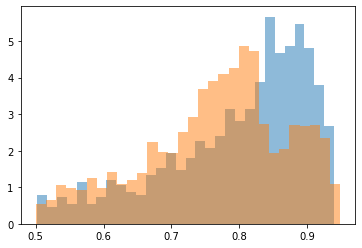

In [207]:
# Select predicted prob by subgroup
y_mask  = (y_class == y_test)
x_group = X_test[:, 2][y_mask]


pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True)
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True)